In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-2di7te9f
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-2di7te9f
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18422 sha256=3e2b679ef4b90069a348ce7c085fe3d67be6579fb2b71c23de40b431d3c1c2d4
  Stored in directory: /tmp/pip-ephem-wheel-cache-px17dtys/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
import efficientnet.keras as effnet

In [ ]:
# CIFAR10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Converting class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [ ]:
from keras.backend import sigmoid

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

In [ ]:
model = effnet.EfficientNetB1(include_top=False, input_shape=(32,32,3), pooling='avg', weights='imagenet')

# Adding 2 fully-connected layers to B0.
x = model.output

x = BatchNormalization()(x)
x = Dropout(0.7)(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)

# Output layer
predictions = Dense(10, activation="softmax")(x)

model_final = Model(inputs = model.input, outputs = predictions)

model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 16, 16, 32)   128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 16, 16, 32)   0           stem_bn[0][0]                    
______________________________________________________________________________________________

In [ ]:
model_final.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.0001),
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('/content/drive/MyDrive/EfficientNet/SGD_B1_30(0.0001).h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1,)

#print("Training....")
m = model_final.fit(x_train, y_train,
              batch_size=32,
              epochs=30,
              validation_split=0.1,
              callbacks=[mcp_save, reduce_lr],
              shuffle=True,
              verbose=1)

Epoch 1/30
1407/1407 [==============================] - 74s 44ms/step - loss: 2.2700 - accuracy: 0.1963 - val_loss: 1.3231 - val_accuracy: 0.5394
Epoch 2/30
1407/1407 [==============================] - 59s 42ms/step - loss: 1.3960 - accuracy: 0.5052 - val_loss: 0.9348 - val_accuracy: 0.6778
Epoch 3/30
1407/1407 [==============================] - 59s 42ms/step - loss: 1.0643 - accuracy: 0.6382 - val_loss: 0.7487 - val_accuracy: 0.7416
Epoch 4/30
1407/1407 [==============================] - 59s 42ms/step - loss: 0.8936 - accuracy: 0.6979 - val_loss: 0.6571 - val_accuracy: 0.7794
Epoch 5/30
1407/1407 [==============================] - 59s 42ms/step - loss: 0.7583 - accuracy: 0.7465 - val_loss: 0.5842 - val_accuracy: 0.8028
Epoch 6/30
1407/1407 [==============================] - 58s 42ms/step - loss: 0.6718 - accuracy: 0.7721 - val_loss: 0.5417 - val_accuracy: 0.8142
Epoch 7/30
1407/1407 [==============================] - 59s 42ms/step - loss: 0.5943 - accuracy: 0.8001 - val_loss: 0.5061 -

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

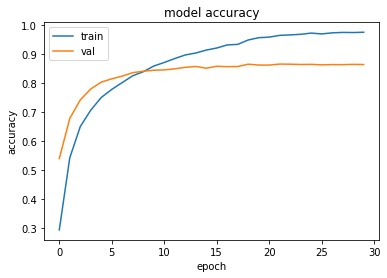

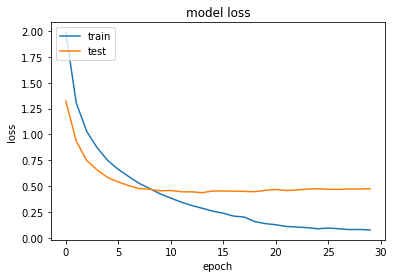

In [ ]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
_, acc = model_final.evaluate(x_test, y_test)
print("Test Accuracy: {}%".format(acc*100))

313/313 [==============================] - 4s 11ms/step - loss: 0.5097 - accuracy: 0.8585
Test Accuracy: 85.85000038146973%


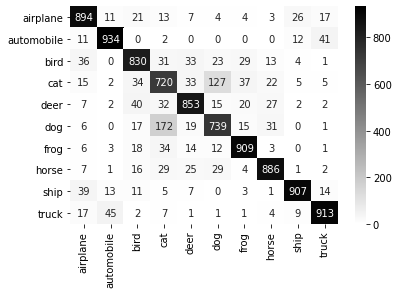

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_pred = model_final.predict(x_test)
import numpy as np
categories = ['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']
ax = sns.heatmap(confusion_matrix(np.argmax(y_test, axis=1),np.argmax(test_pred, axis=1)), cmap="binary", annot=True, fmt="d")
ax.xaxis.set_ticklabels(categories,rotation=90)
ax.yaxis.set_ticklabels(categories,rotation=360);